In [145]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as datetime
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

In [184]:
# os.chdir("/Users/mckenziehumann/Dropbox (MIT)/Fall 2021/GIS/Final Project/bluebikes/")
station_data = pd.read_csv("../../data/bluebikes/station_statuses.csv")
station_info = pd.read_csv("../../data/bluebikes/all_station_info.csv")[['station_id','legacy_id','short_name','name','lat','lon','opened']]
trips = pd.read_csv("../../data/bluebikes/202110-blueblikes-tripdata.csv")


In [147]:
station_info['opened'] = pd.to_datetime(station_info['opened'])
station_info['new'] = station_info['opened'] > '2018-01-01'

In [148]:
station_data = station_data.merge(station_info,on='station_id',how='outer')


In [149]:
station_data = station_data.loc[station_data['station_status']=='active'].copy()
station_data['last_updated'] = pd.to_datetime(station_data['last_updated'])
station_data['dock_capacity'] = station_data['num_bikes_available'] / (station_data['num_docks_available'] + station_data['num_bikes_available'])

In [150]:
station_data['datetime'] = station_data['last_updated'].round('60min')
station_data['day'] = station_data['datetime'].dt.day_name()
station_data['time'] = [datetime.time(d) for d in station_data['datetime']] 
station_data['date'] = station_data['datetime'].dt.date

In [151]:
station_data.station_id.unique().shape

(403,)

In [152]:
station_data.time.value_counts()

14:00:00    5877
06:00:00    5491
01:00:00    5491
02:00:00    5491
04:00:00    5491
15:00:00    5491
21:00:00    5491
22:00:00    5491
08:00:00    5491
07:00:00    5491
05:00:00    5491
03:00:00    5491
23:00:00    5491
00:00:00    5491
16:00:00    5490
19:00:00    5490
20:00:00    5490
17:00:00    5490
18:00:00    5490
09:00:00    5489
10:00:00    5487
11:00:00    5485
12:00:00    5481
13:00:00    5477
Name: time, dtype: int64

In [153]:
station_data['date'].unique()

array([datetime.date(2021, 11, 10), datetime.date(2021, 11, 12),
       datetime.date(2021, 11, 17), datetime.date(2021, 11, 16),
       datetime.date(2021, 11, 8), datetime.date(2021, 11, 14),
       datetime.date(2021, 11, 15), datetime.date(2021, 11, 9),
       datetime.date(2021, 11, 19), datetime.date(2021, 11, 7),
       datetime.date(2021, 11, 18), datetime.date(2021, 11, 20),
       datetime.date(2021, 11, 21), datetime.date(2021, 11, 11),
       datetime.date(2021, 11, 13)], dtype=object)

In [154]:
weekends = [dt.date(2021, 11, 7), dt.date(2021, 11, 11), dt.date(2021, 11, 13),
            dt.date(2021, 11, 14), dt.date(2021, 11, 20), dt.date(2021, 11, 14)]
station_data['i_weekend'] = (station_data['date'].isin(weekends))
# station_data['i_weekend'].loc[station_data['date'] == '2021-11-11'] = True

In [155]:
station_data[['i_weekend','date']].value_counts()

i_weekend  date      
False      2021-11-08    9649
           2021-11-09    9599
           2021-11-10    9533
True       2021-11-11    9453
False      2021-11-12    9422
           2021-11-15    9408
True       2021-11-13    9408
           2021-11-14    9408
False      2021-11-16    9375
           2021-11-17    9324
           2021-11-18    9265
           2021-11-19    9240
True       2021-11-20    9240
False      2021-11-21    5775
True       2021-11-07    4030
dtype: int64

In [156]:
avg_day_dock_capacity = station_data.groupby(['short_name','time','i_weekend'])['dock_capacity'].mean().to_frame(name='dock_capacity').reset_index()


In [157]:
weekend_dock_capacity = avg_day_dock_capacity.loc[avg_day_dock_capacity['i_weekend']][['short_name','time','dock_capacity']]
weekday_dock_capacity = avg_day_dock_capacity.loc[~(avg_day_dock_capacity['i_weekend'])][['short_name','time','dock_capacity']]
                                                

In [158]:
weekday_dock_capacity = weekday_dock_capacity.pivot(index="time", columns="short_name", values="dock_capacity").reset_index()
weekend_dock_capacity = weekend_dock_capacity.pivot(index="time", columns="short_name", values="dock_capacity").reset_index()




In [159]:

fig = px.line(weekday_dock_capacity, 
              x="time", 
              y=weekday_dock_capacity.columns, 
#               color_discrete_sequence=['gray'],
#               width=1,
#               hover_data={"time": "|"},
              title='Weekday Station Capacity')
fig.update_traces(line=dict(color="Black", width=0.5))

# fig.update_xaxes(
#     dtick="M1",
#     tickformat="%b\n%Y")
fig.show()

/Users/mckenziehumann/opt/anaconda3/envs/BigData21/lib/python3.9/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [160]:
fig = px.line(weekend_dock_capacity, 
              x="time", 
              y=weekday_dock_capacity.columns, 
              title='Weekend Dock Capacity')
fig.update_traces(line=dict(color="Black", width=0.5))
fig.show()

In [161]:
day_weekends = ['Saturday','Sunday']
trips['started_at'] = pd.to_datetime(trips['started_at'])
trips['day'] = trips['started_at'].dt.day_name()
trips['date'] = trips['started_at'].dt.date

trips['i_weekend'] = (trips['day'].isin(day_weekends))
weekday_trips = trips[~trips['i_weekend']].copy()
weekend_trips = trips[trips['i_weekend']].copy()

In [162]:
station_start_wd = weekday_trips.groupby(['start_station_id','start_station_name']).size().to_frame(name='count').reset_index().sort_values('count',ascending=False)
station_end_wd = weekday_trips.groupby(['end_station_id','end_station_name']).size().to_frame(name='count').reset_index().sort_values('count',ascending=False)
station_start_wd['proportion'] = station_start_wd['count'] / station_start_wd['count'].sum()
station_end_wd['proportion'] = station_end_wd['count'] / station_end_wd['count'].sum()

print(station_start_wd[:10]['start_station_name'], '\n\n')
print(station_end_wd[:10]['end_station_name'])

station_start_wd = station_start_wd.rename(columns = {'start_station_id':'short_name',
                                                              'start_station_name':'station_name',
                                                              'count':'start_count_wd',
                                                             'proportion':'start_proportion_wd'})

station_end_wd = station_end_wd.rename(columns = {'end_station_id':'short_name',
                                                              'end_station_name':'station_name',
                                                              'count':'end_count_wd',
                                                             'proportion':'end_proportion_wd'})

station_start_we = weekend_trips.groupby(['start_station_id','start_station_name']).size().to_frame(name='count').reset_index().sort_values('count',ascending=False)
station_end_we = weekend_trips.groupby(['end_station_id','end_station_name']).size().to_frame(name='count').reset_index().sort_values('count',ascending=False)
station_start_we['proportion'] = station_start_we['count'] / station_start_we['count'].sum()
station_end_we['proportion'] = station_end_we['count'] / station_end_we['count'].sum()

print(station_start_we[:10]['start_station_name'], '\n\n')
print(station_end_we[:10]['end_station_name'])

station_start_we = station_start_we.rename(columns = {'start_station_id':'short_name',
                                                              'start_station_name':'station_name',
                                                              'count':'start_count_we',
                                                             'proportion':'start_proportion_we'})

station_end_we = station_end_we.rename(columns = {'end_station_id':'short_name',
                                                              'end_station_name':'station_name',
                                                              'count':'end_count_we',
                                                             'proportion':'end_proportion_we'})



267                   MIT at Mass Ave / Amherst St
294                             Ames St at Main St
270          Central Square at Mass Ave / Essex St
276            Harvard Square at Mass Ave/ Dunster
58                  Beacon St at Massachusetts Ave
298                MIT Pacific St at Purrington St
2                  Commonwealth Ave at Agganis Way
266        MIT Stata Center at Vassar St / Main St
299                                  MIT Vassar St
189    Charles Circle - Charles St at Cambridge St
Name: start_station_name, dtype: object 


268                   MIT at Mass Ave / Amherst St
295                             Ames St at Main St
271          Central Square at Mass Ave / Essex St
277            Harvard Square at Mass Ave/ Dunster
58                  Beacon St at Massachusetts Ave
2                  Commonwealth Ave at Agganis Way
299                MIT Pacific St at Purrington St
267        MIT Stata Center at Vassar St / Main St
190    Charles Circle - Charles St at C

In [163]:
station_counts = station_start_wd.merge(station_end_wd, on=['short_name','station_name'],how='outer')
station_counts = station_counts.merge(station_start_we, on=['short_name','station_name'],how='outer')
station_counts = station_counts.merge(station_end_we, on=['short_name','station_name'],how='outer')


In [164]:
cluster_data = weekday_dock_capacity.set_index('time').transpose().reset_index()
cluster_data = cluster_data.merge(weekday_dock_capacity.set_index('time').transpose().reset_index(), on='short_name', suffixes=['_wd','_we'])
cluster_data = cluster_data.merge(station_counts[['short_name','start_proportion_wd','end_proportion_wd','start_proportion_we','end_proportion_we']],on='short_name',how='left').set_index('short_name')

                                  
                                  

In [165]:
print(cluster_data.shape)

is_NaN = cluster_data.isnull()
row_has_NaN = is_NaN.any(axis=1)
cluster_data = cluster_data[~row_has_NaN].copy()
print(cluster_data.shape)

standardize_cluster_data = StandardScaler().fit_transform(cluster_data)
pca = PCA(.97)
principalComponents = pca.fit_transform(standardize_cluster_data)
print(principalComponents.shape)
cluster_data_pca = pd.DataFrame(data = principalComponents
             , columns = ['pc_' + str(i) for i in range(1,principalComponents.shape[1]+1)])
cluster_data_pca['short_name'] = cluster_data.index
cluster_data_pca = cluster_data_pca.set_index('short_name')
print(cluster_data_pca)



(403, 52)
(398, 52)
(398, 4)
                pc_1      pc_2      pc_3      pc_4
short_name                                        
A32000     -7.811843  4.234630 -1.451719 -0.763081
A32001     -1.077722 -3.426875  0.293842  2.742966
A32002      4.147469 -0.445835  7.068198 -1.238289
A32003      3.618603  8.193680  1.765090  4.171897
A32004      1.282409  4.971051  2.397058 -1.803740
...              ...       ...       ...       ...
W32004     -0.375471  0.783785 -0.621883 -0.782380
W32005      1.759554 -0.705179 -1.228414 -0.270478
W32006     -3.296194  0.788151 -1.547358 -0.280402
W32007      4.811820 -1.994738 -0.900311  0.101680
W32008      7.562341 -1.514365 -0.638675 -0.635911

[398 rows x 4 columns]


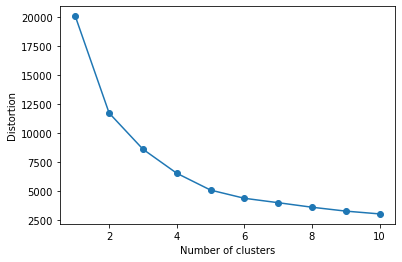

In [166]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# km = KMeans(
#     n_clusters=3, init='random',
#     n_init=10, max_iter=300, 
#     tol=1e-04, random_state=0
# )
# y_km = km.fit_predict(X)

distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(cluster_data_pca)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [167]:
km = KMeans(
    n_clusters=5, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
cluster_data_pca['cluster'] = km.fit_predict(cluster_data_pca)
cluster_data['cluster'] = cluster_data_pca['cluster']

In [208]:
for x in range(0,2):
    temp = cluster_data.reset_index()
    cluster_docks = temp[temp['cluster'] == x]['short_name'].to_list()
    cluster_docks.append('time')

#     print(weekday_dock_capacity[cluster_docks])
    fig = px.line(weekday_dock_capacity[cluster_docks].copy(), 
                  x="time", 
                  y=weekday_dock_capacity[cluster_docks].columns, 
    #               color_discrete_sequence=['gray'],
    #               width=1,
    #               hover_data={"time": "|"},
                  title='Weekday Station Capacity cluster {}'.format(x))
    fig.update_traces(line=dict(color="Black", width=0.5))

    # fig.update_xaxes(
    #     dtick="M1",
    #     tickformat="%b\n%Y")
    fig.show()
    

    
#     print(weekday_dock_capacity[cluster_docks])
    fig = px.line(weekend_dock_capacity[cluster_docks].copy(), 
                  x="time", 
                  y=weekend_dock_capacity[cluster_docks].columns, 
    #               color_discrete_sequence=['gray'],
    #               width=1,
    #               hover_data={"time": "|"},
                  title='Weekend Station Capacity cluster {}'.format(x))
    fig.update_traces(line=dict(color="Black", width=0.5))

    # fig.update_xaxes(
    #     dtick="M1",
    #     tickformat="%b\n%Y")
    fig.show()

/Users/mckenziehumann/opt/anaconda3/envs/BigData21/lib/python3.9/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



In [209]:
for x in range(2,5):
    temp = cluster_data.reset_index()
    cluster_docks = temp[temp['cluster'] == x]['short_name'].to_list()
    cluster_docks.append('time')

#     print(weekday_dock_capacity[cluster_docks])
    fig = px.line(weekday_dock_capacity[cluster_docks], 
                  x="time", 
                  y=weekday_dock_capacity[cluster_docks].columns, 
    #               color_discrete_sequence=['gray'],
    #               width=1,
    #               hover_data={"time": "|"},
                  title='Weekday Station Capacity cluster {}'.format(x))
    fig.update_traces(line=dict(color="Black", width=0.5))

    # fig.update_xaxes(
    #     dtick="M1",
    #     tickformat="%b\n%Y")
    fig.show()
    

    
#     print(weekday_dock_capacity[cluster_docks])
    fig = px.line(weekend_dock_capacity[cluster_docks], 
                  x="time", 
                  y=weekend_dock_capacity[cluster_docks].columns, 
    #               color_discrete_sequence=['gray'],
    #               width=1,
    #               hover_data={"time": "|"},
                  title='Weekend Station Capacity cluster {}'.format(x))
    fig.update_traces(line=dict(color="Black", width=0.5))

    # fig.update_xaxes(
    #     dtick="M1",
    #     tickformat="%b\n%Y")
    fig.show()

In [170]:
for x in range(0,5):
    temp = cluster_data.reset_index()
    cluster_docks = temp[temp['cluster'] == x]['short_name'].to_list()
    print("{} docks in cluster {} ".format(len(cluster_docks), x))

    cluster_docks.append('time')
    print('{:.2%} weekday trips start from docks in this cluster'.format(temp[temp['cluster'] == x]['start_proportion_wd'].sum()))
    print('{:.2%} weekday trips end at docks in this cluster'.format(temp[temp['cluster'] == x]['end_proportion_wd'].sum()))

    print('{:.2%} weekend trips start from docks in this cluster'.format(temp[temp['cluster'] == x]['start_proportion_we'].sum()))
    print('{:.2%} weekend trips end at docks in this cluster \n'.format(temp[temp['cluster'] == x]['end_proportion_we'].sum()))


119 docks in cluster 0 
17.33% weekday trips start from docks in this cluster
16.99% weekday trips end at docks in this cluster
17.38% weekend trips start from docks in this cluster
17.22% weekend trips end at docks in this cluster 

63 docks in cluster 1 
2.92% weekday trips start from docks in this cluster
2.83% weekday trips end at docks in this cluster
3.36% weekend trips start from docks in this cluster
3.34% weekend trips end at docks in this cluster 

54 docks in cluster 2 
32.88% weekday trips start from docks in this cluster
33.10% weekday trips end at docks in this cluster
26.79% weekend trips start from docks in this cluster
27.00% weekend trips end at docks in this cluster 

63 docks in cluster 3 
27.06% weekday trips start from docks in this cluster
26.90% weekday trips end at docks in this cluster
30.25% weekend trips start from docks in this cluster
30.08% weekend trips end at docks in this cluster 

99 docks in cluster 4 
18.90% weekday trips start from docks in this cl

In [171]:
cluster_data = cluster_data.merge(station_info, on='short_name',how='left')


In [172]:
new_cluster_data = cluster_data.groupby(['cluster','new']).agg({'station_id':'count', 
                                                                'start_proportion_wd':'sum',
                                                                'start_proportion_we':'sum',
                                                                'end_proportion_wd':'sum',
                                                                'end_proportion_we':'sum'}).reset_index().sort_values(by=['cluster','new'])
total_stations_per_cluster = cluster_data[['cluster']].value_counts().to_frame(name='total').reset_index()
new_cluster_data = new_cluster_data.merge(total_stations_per_cluster, on='cluster')

new_cluster_data['perc_cluster'] = new_cluster_data['station_id'] / new_cluster_data['total']
old_cluster_data = new_cluster_data[~(new_cluster_data['new'])].set_index('cluster').transpose().reset_index()

new_cluster_data = new_cluster_data[new_cluster_data['new']].set_index('cluster').transpose().reset_index()
print(old_cluster_data)
print(new_cluster_data)

# cluster_analysis = 

cluster                index         0         1         2         3         4
0                        new     False     False     False     False     False
1                 station_id        46        15        40        40        43
2        start_proportion_wd  0.106276  0.012187   0.25812  0.195725  0.121241
3        start_proportion_we  0.103789  0.013658  0.214867  0.221528  0.140866
4          end_proportion_wd  0.104657  0.011838  0.260613  0.194712  0.122875
5          end_proportion_we  0.102525  0.013656  0.217059  0.220161  0.140384
6                      total       119        63        54        63        99
7               perc_cluster  0.386555  0.238095  0.740741  0.634921  0.434343
cluster                index         0         1         2         3         4
0                        new      True      True      True      True      True
1                 station_id        73        48        14        23        56
2        start_proportion_wd   0.06706  0.016965  0.

In [175]:
cluster_data.to_csv("../../data/bluebikes/cluster_data.csv")

In [185]:
trips = trips.merge(cluster_data[['short_name','cluster','new']],left_on='start_station_id', right_on='short_name',how='left')
trips = trips.merge(cluster_data[['short_name','cluster','new']],left_on='end_station_id', right_on='short_name',how='left',suffixes=['_start','_end'])


In [193]:
new_trips = trips[trips['new_start'] | trips['new_end']]
old_trips = trips[(trips['new_start']==False) & (trips['new_end']==False)]

In [188]:
cluster_trip_counts = trips[['cluster_start','cluster_end']].value_counts().to_frame(name='counts').reset_index().sort_values(by=['cluster_start','cluster_end'])
cluster_start_counts = trips[['cluster_start']].value_counts().to_frame(name='start_counts').reset_index()
cluster_end_counts = trips[['cluster_end']].value_counts().to_frame(name='end_counts').reset_index()

cluster_trip_counts = cluster_trip_counts.merge(cluster_start_counts, on='cluster_start')
cluster_trip_counts = cluster_trip_counts.merge(cluster_end_counts, on='cluster_end')
cluster_trip_counts['perc_start_cluster'] = cluster_trip_counts['counts']/cluster_trip_counts['start_counts']
cluster_trip_counts['perc_end_cluster'] = cluster_trip_counts['counts']/cluster_trip_counts['end_counts']
cluster_trip_counts

cluster_start  cluster_end  counts  start_counts  end_counts  \
0             0.0          0.0   15726         70187       68588   
1             1.0          0.0    2777         12406       68588   
2             2.0          0.0   20059        124662       68588   
3             3.0          0.0   16562        113856       68588   
4             4.0          0.0   12984         80053       68588   
5             0.0          1.0    3037         70187       12064   
6             1.0          1.0    2101         12406       12064   
7             2.0          1.0    2219        124662       12064   
8             3.0          1.0    2049        113856       12064   
9             4.0          1.0    2428         80053       12064   
10            0.0          2.0   20666         70187      124724   
11            1.0          2.0    2604         12406      124724   
12            2.0          2.0   37523        124662      124724   
13            3.0          2.0   43743        113856      124724   
14            4.0          2.0   19633         80053      124724   
15            0.0          3.0   16813         70187      112420   
16            1.0          3.0    1885         12406      112420   
17            2.0          3.0   43330        124662      112420   
18            3.0          3.0   30821        113856      112420   
19            4.0          3.0   18905         80053      112420   
20            0.0          4.0   13069         70187       80482   
21            1.0          4.0    2683         12406       80482   
22            2.0          4.0   20225        124662       80482   
23            3.0          4.0   19124        113856       80482   
24            4.0          4.0   24223         80053       80482   

    perc_start_cluster  perc_end_cluster  
0             0.224059          0.229282  
1             0.223843          0.040488  
2             0.160907          0.292456  
3             0.145464          0.241471  
4             0.162193          0.189304  
5             0.043270          0.251741  
6             0.169354          0.174155  
7             0.017800          0.183936  
8             0.017996          0.169844  
9             0.030330          0.201260  
10            0.294442          0.165694  
11            0.209898          0.020878  
12            0.300998          0.300848  
13            0.384196          0.350718  
14            0.245250          0.157412  
15            0.239546          0.149555  
16            0.151943          0.016767  
17            0.347580          0.385430  
18            0.270702          0.274159  
19            0.236156          0.168164  
20            0.186203          0.162384  
21            0.216266          0.033337  
22            0.162239          0.251298  
23            0.167967          0.237618  
24            0.302587          0.300974

In [102]:
G = nx.from_pandas_edgelist(cluster_trip_counts, 'cluster_start', 'cluster_end', edge_attr =['counts','perc_start_cluster', 'perc_end_cluster'],create_using=nx.DiGraph())
for i in list(G.nodes()):
    G.nodes[i]['start_counts'] = cluster_start_counts.loc[cluster_start_counts['cluster_start'] == i, 'start_counts'].item()
    G.nodes[i]['end_counts'] = cluster_end_counts.loc[cluster_end_counts['cluster_end'] == i, 'end_counts'].item()
  

In [199]:
def draw_graph(G, node_weight,edge_weight,weight=50):
    # fixing the size of the figure
    plt.figure(figsize =(12, 10))
    pos = nx.spring_layout(G)

    # node_color = [G.degree(v) for v in G]
    # # node colour is a list of degrees of nodes

    node_size = [.1 * nx.get_node_attributes(G, node_weight)[v] for v in G]
    # size of node is a list of population of cities

    edge_width = [weight * G[u][v][edge_weight] for u, v in G.edges()]
    # width of edge is a list of weight of edges

    nx.draw_networkx(G, node_size = node_size, 
                      alpha = 0.7,
                     with_labels = True, width = edge_width,
                     edge_color ='.4', cmap = plt.cm.Blues, connectionstyle='arc3, rad = 0.1')

    # edge_labels = nx.get_edge_attributes(G,'perc_start_cluster') # key is edge, pls check for your case
    # formatted_edge_labels = {(elem[0],elem[1]):edge_labels[elem] for elem in edge_labels} # use this to modify the tuple keyed dict if it has > 2 elements, else ignore
    # nx.draw_networkx_edge_labels(G,pos,edge_labels=formatted_edge_labels,font_color='red')

    plt.axis('off')
    plt.tight_layout();

All Stations

Start Counts, Percent of Start Cluster

End Counts, Percent of End Cluster

Start Counts, Total Counts



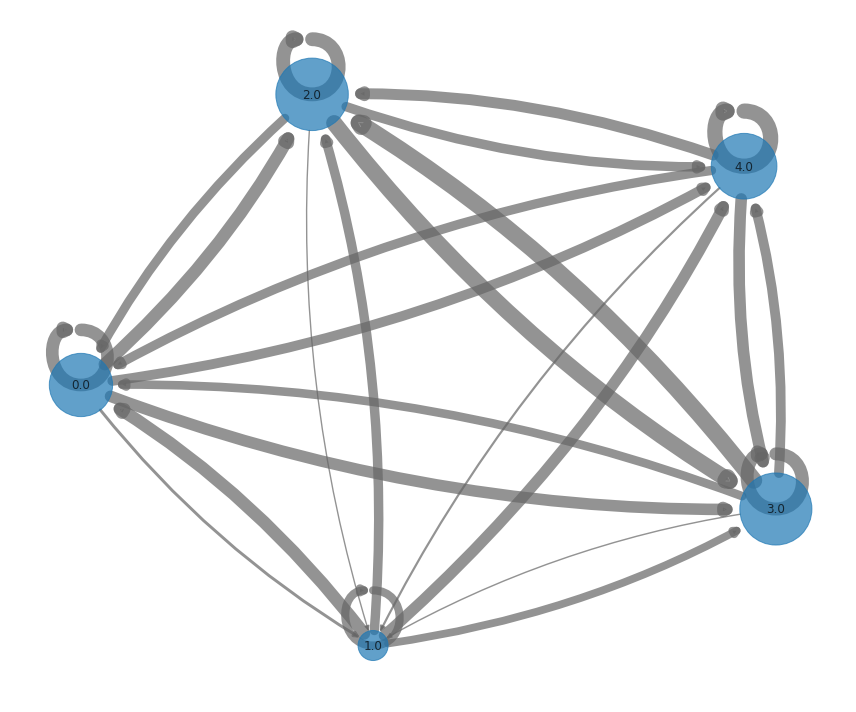

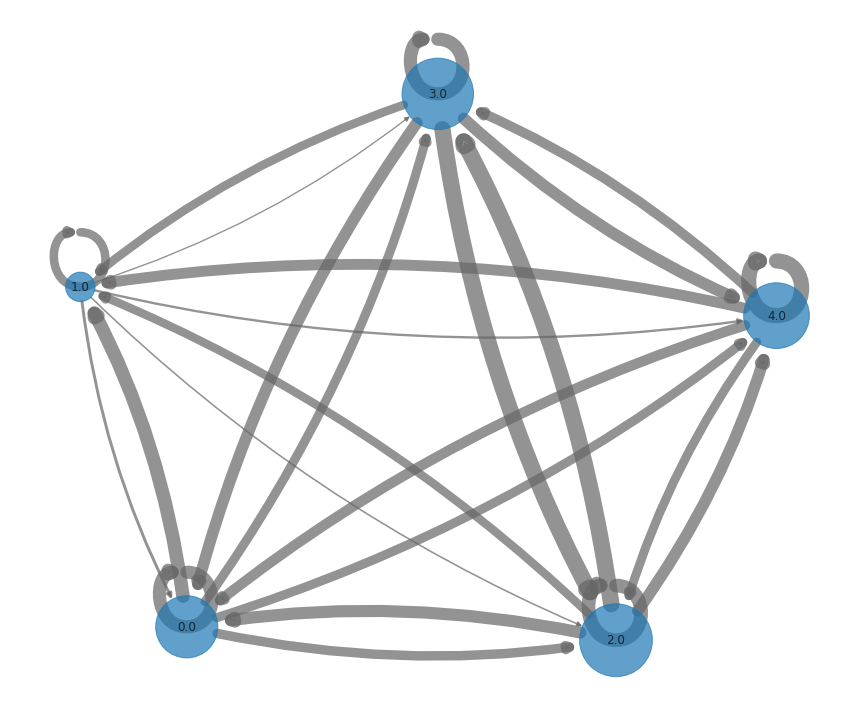

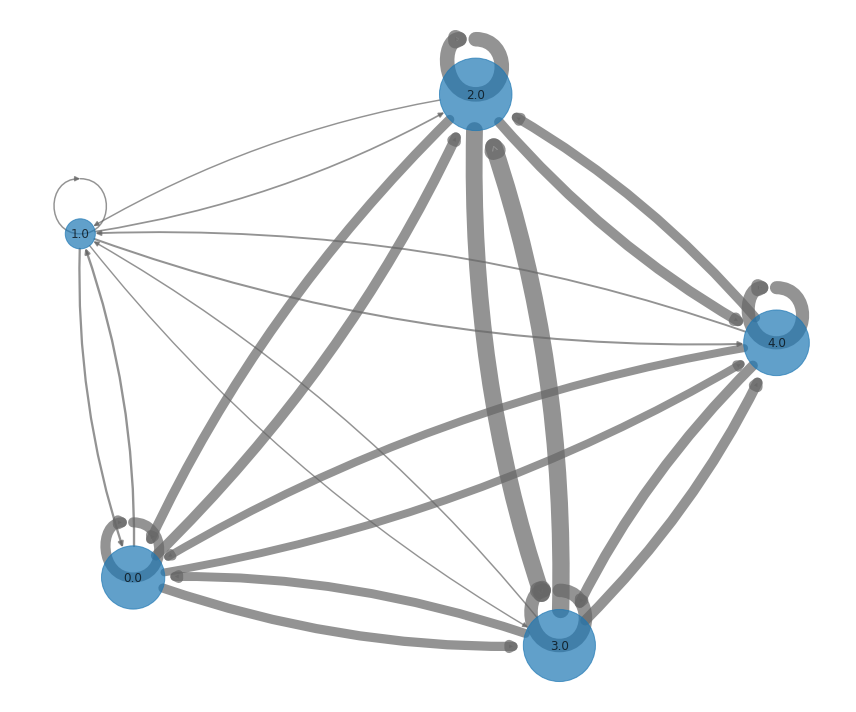

In [200]:
print("All Stations\n")
print("Start Counts, Percent of Start Cluster\n")
draw_graph(G,'start_counts','perc_start_cluster')
print("End Counts, Percent of End Cluster\n")
draw_graph(G,'end_counts','perc_end_cluster')
print("Start Counts, Total Counts\n")
draw_graph(G,'start_counts','counts',0.001)

In [201]:
new_cluster_trip_counts = new_trips[['cluster_start','cluster_end']].value_counts().to_frame(name='counts').reset_index().sort_values(by=['cluster_start','cluster_end'])
new_cluster_start_counts = new_trips[['cluster_start']].value_counts().to_frame(name='start_counts').reset_index()
new_cluster_end_counts = new_trips[['cluster_end']].value_counts().to_frame(name='end_counts').reset_index()

new_cluster_trip_counts = new_cluster_trip_counts.merge(new_cluster_start_counts, on='cluster_start')
new_cluster_trip_counts = new_cluster_trip_counts.merge(new_cluster_end_counts, on='cluster_end')
new_cluster_trip_counts['perc_start_cluster'] = new_cluster_trip_counts['counts']/new_cluster_trip_counts['start_counts']
new_cluster_trip_counts['perc_end_cluster'] = new_cluster_trip_counts['counts']/new_cluster_trip_counts['end_counts']


In [202]:
G = nx.from_pandas_edgelist(new_cluster_trip_counts, 'cluster_start', 'cluster_end', edge_attr =['counts','perc_start_cluster', 'perc_end_cluster'],create_using=nx.DiGraph())
for i in list(G.nodes()):
    G.nodes[i]['start_counts'] = new_cluster_start_counts.loc[new_cluster_start_counts['cluster_start'] == i, 'start_counts'].item()
    G.nodes[i]['end_counts'] = new_cluster_end_counts.loc[new_cluster_end_counts['cluster_end'] == i, 'end_counts'].item()
  

All Stations

Start Counts, Percent of Start Cluster

End Counts, Percent of End Cluster

Start Counts, Total Counts



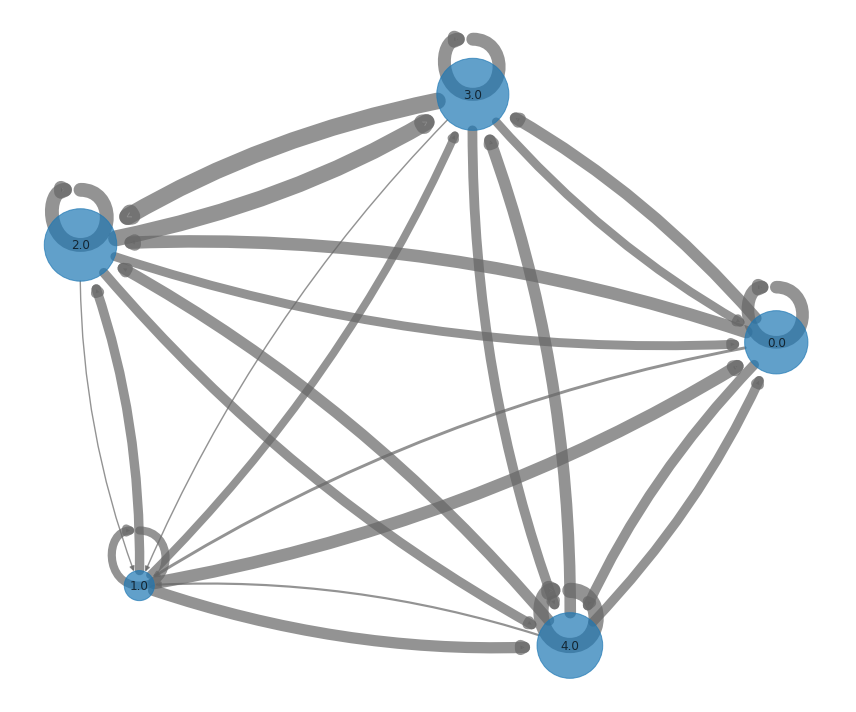

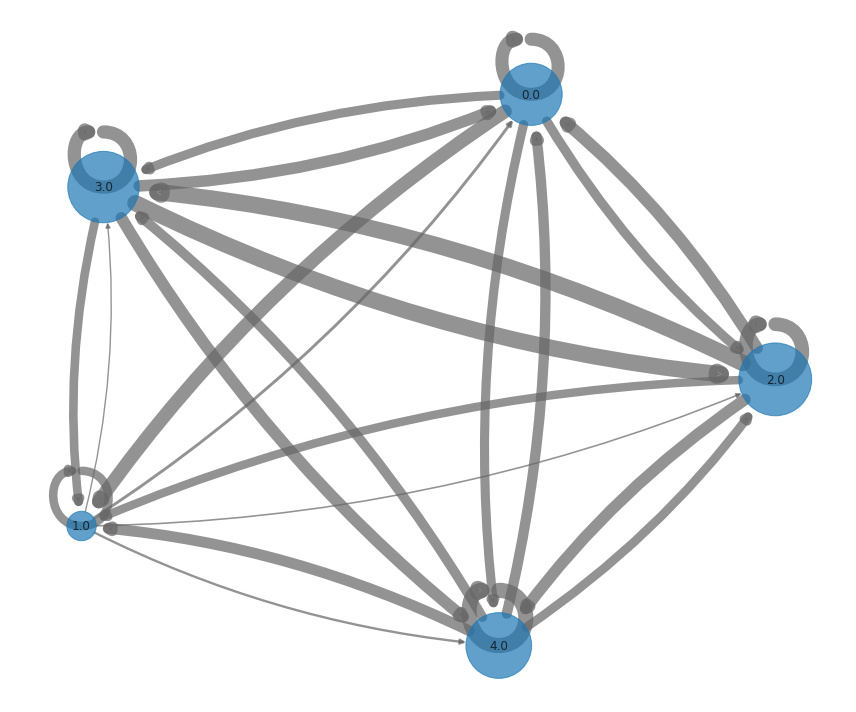

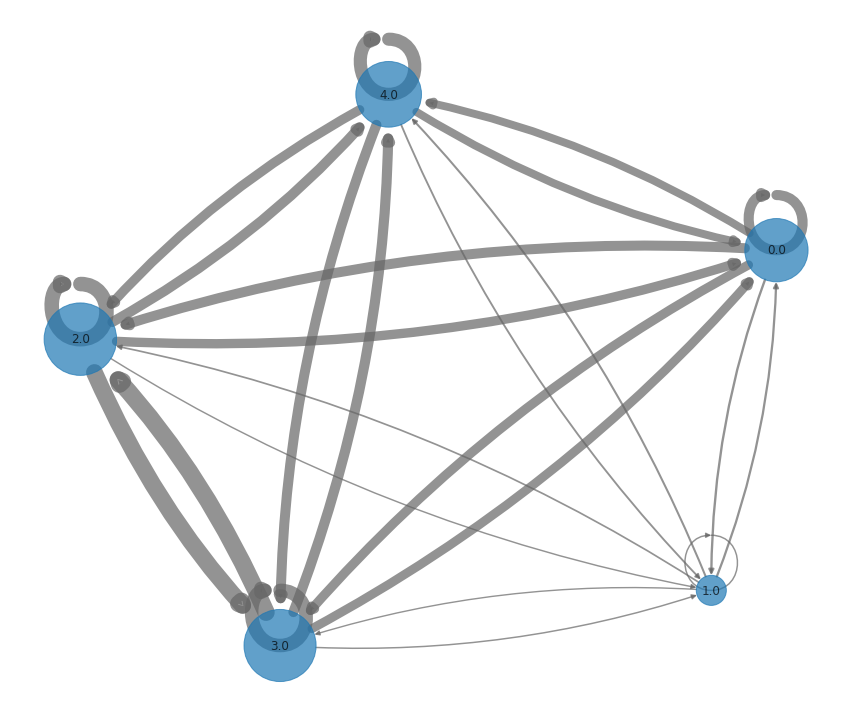

In [203]:
print("All Stations\n")
print("Start Counts, Percent of Start Cluster\n")
draw_graph(G,'start_counts','perc_start_cluster')
print("End Counts, Percent of End Cluster\n")
draw_graph(G,'end_counts','perc_end_cluster')
print("Start Counts, Total Counts\n")
draw_graph(G,'start_counts','counts',0.001)

In [204]:
old_cluster_trip_counts = old_trips[['cluster_start','cluster_end']].value_counts().to_frame(name='counts').reset_index().sort_values(by=['cluster_start','cluster_end'])
old_cluster_start_counts = old_trips[['cluster_start']].value_counts().to_frame(name='start_counts').reset_index()
old_cluster_end_counts = old_trips[['cluster_end']].value_counts().to_frame(name='end_counts').reset_index()

old_cluster_trip_counts = old_cluster_trip_counts.merge(old_cluster_start_counts, on='cluster_start')
old_cluster_trip_counts = old_cluster_trip_counts.merge(old_cluster_end_counts, on='cluster_end')
old_cluster_trip_counts['perc_start_cluster'] = old_cluster_trip_counts['counts']/old_cluster_trip_counts['start_counts']
old_cluster_trip_counts['perc_end_cluster'] = old_cluster_trip_counts['counts']/old_cluster_trip_counts['end_counts']


In [205]:
G = nx.from_pandas_edgelist(old_cluster_trip_counts, 'cluster_start', 'cluster_end', edge_attr =['counts','perc_start_cluster', 'perc_end_cluster'],create_using=nx.DiGraph())
for i in list(G.nodes()):
    G.nodes[i]['start_counts'] = old_cluster_start_counts.loc[old_cluster_start_counts['cluster_start'] == i, 'start_counts'].item()
    G.nodes[i]['end_counts'] = old_cluster_end_counts.loc[old_cluster_end_counts['cluster_end'] == i, 'end_counts'].item()
  

All Stations

Start Counts, Percent of Start Cluster

End Counts, Percent of End Cluster

Start Counts, Total Counts



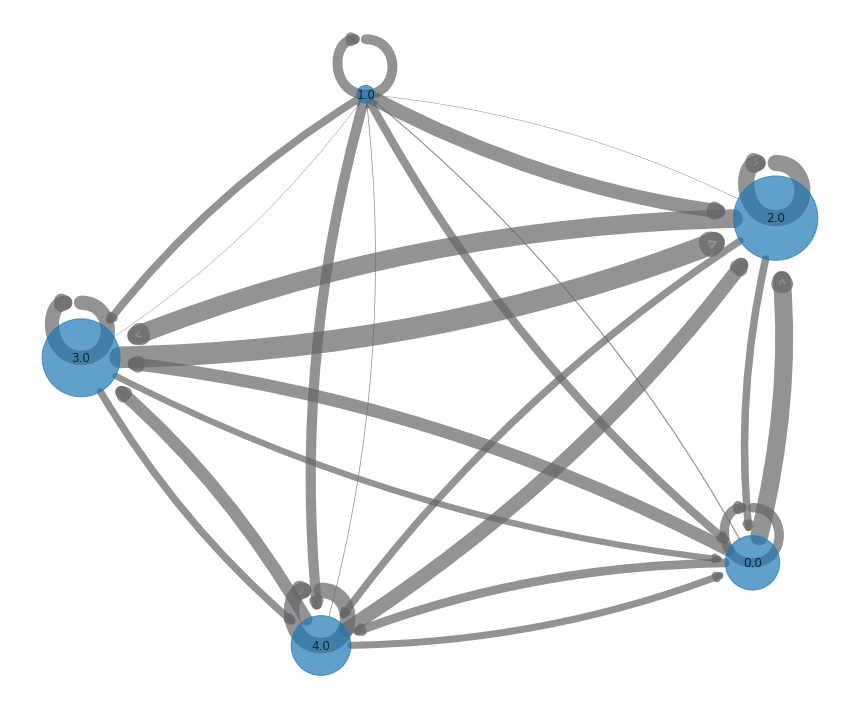

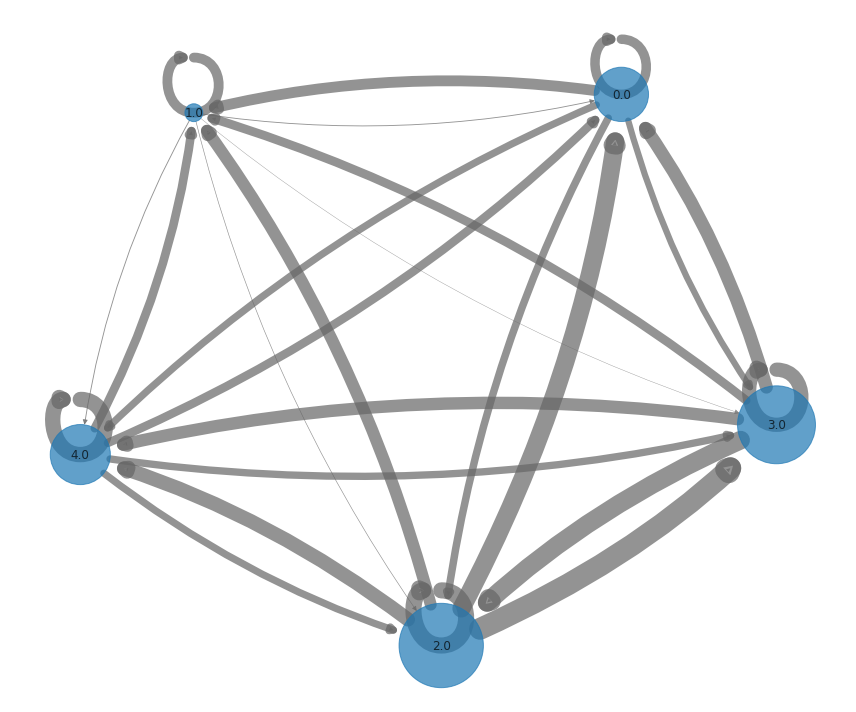

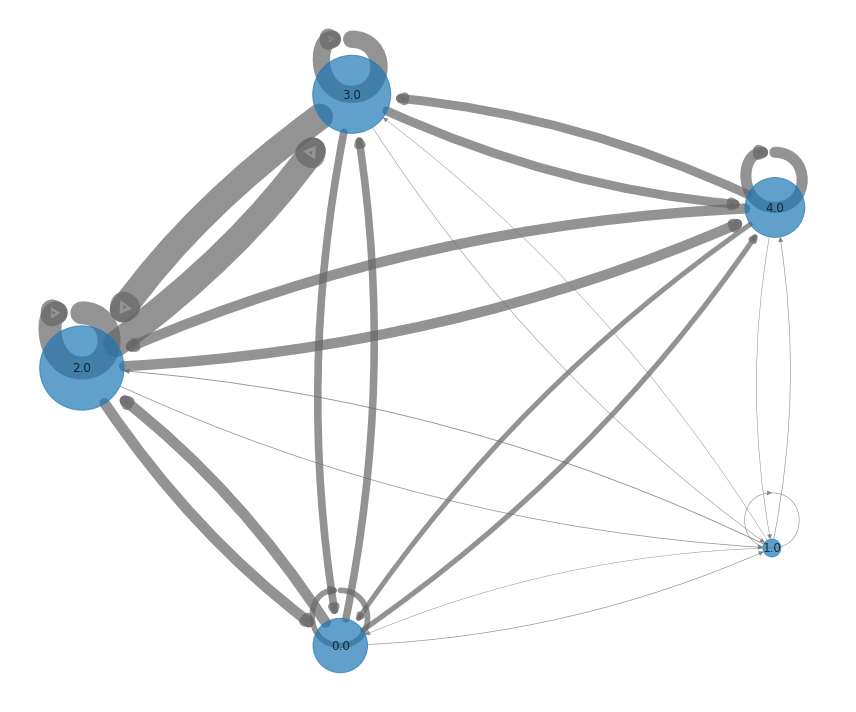

In [206]:
print("All Stations\n")
print("Start Counts, Percent of Start Cluster\n")
draw_graph(G,'start_counts','perc_start_cluster')
print("End Counts, Percent of End Cluster\n")
draw_graph(G,'end_counts','perc_end_cluster')
print("Start Counts, Total Counts\n")
draw_graph(G,'start_counts','counts',0.001)

In [207]:
new_cluster_trip_counts - old_cluster_trip_counts

cluster_start  cluster_end  counts  start_counts  end_counts  \
0             0.0          0.0    4516         10337        9228   
1             0.0          0.0    1747          5868        9228   
2             0.0          0.0   -1311        -18580        9228   
3             0.0          0.0    1280         -8911        9228   
4             0.0          0.0    2996          7384        9228   
5             0.0          0.0    1655         10337        5462   
6             0.0          0.0     853          5868        5462   
7             0.0          0.0     695        -18580        5462   
8             0.0          0.0     929         -8911        5462   
9             0.0          0.0    1330          7384        5462   
10            0.0          0.0    -626         10337      -18063   
11            0.0          0.0     804          5868      -18063   
12            0.0          0.0   -8391        -18580      -18063   
13            0.0          0.0   -9063         -8911      -18063   
14            0.0          0.0    -787          7384      -18063   
15            0.0          0.0    1687         10337       -9684   
16            0.0          0.0     917          5868       -9684   
17            0.0          0.0   -9596        -18580       -9684   
18            0.0          0.0   -3789         -8911       -9684   
19            0.0          0.0    1097          7384       -9684   
20            0.0          0.0    2699         10337        7108   
21            0.0          0.0    1389          5868        7108   
22            0.0          0.0    -229        -18580        7108   
23            0.0          0.0    1190         -8911        7108   
24            0.0          0.0    2059          7384        7108   

    perc_start_cluster  perc_end_cluster  
0             0.064070          0.071354  
1             0.087816          0.041005  
2             0.028211         -0.120519  
3             0.046156         -0.028837  
4             0.045549          0.036998  
5             0.035337          0.054390  
6            -0.033424         -0.025066  
7             0.017027         -0.070693  
8             0.019455         -0.003590  
9             0.028212          0.044959  
10           -0.108241          0.039169  
11           -0.095374          0.019463  
12           -0.045537         -0.048255  
13           -0.100032         -0.044424  
14           -0.067168          0.034047  
15           -0.023638          0.056691  
16            0.002331          0.019481  
17           -0.051035         -0.105329  
18           -0.024168         -0.020164  
19           -0.017222          0.049321  
20            0.022329          0.038835  
21            0.021170          0.029194  
22            0.046536         -0.051884  
23            0.048159         -0.013310  
24           -0.005348         -0.002835